# Propensity Score Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 

In [1]:
import numpy as np
import pandas as pd
import patsy as ps
import statsmodels
import dowhy
from dowhy import CausalModel
import econml
from IPython.display import Image, display
from pathlib import Path
import os
import sys

# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
import warnings
warnings.filterwarnings('ignore')
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve Estimation (no causal inference)

In [3]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---
## I. Model a causal problem
* Create a causal model from the data and given graph.

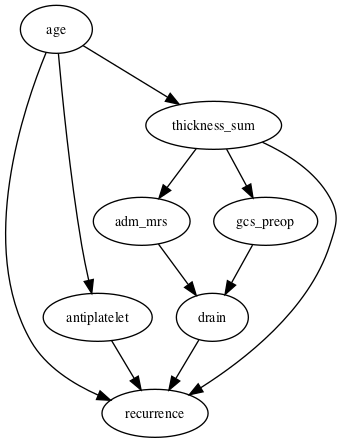

In [4]:
mp_model = CausalModel(data=csdh, 
                       treatment='drain', 
                       outcome='recurrence', 
                       graph='../causal_graphs/mp_dag.dot'.replace("\n", " "))
mp_model.view_model()
display(Image(filename="causal_model.png"))

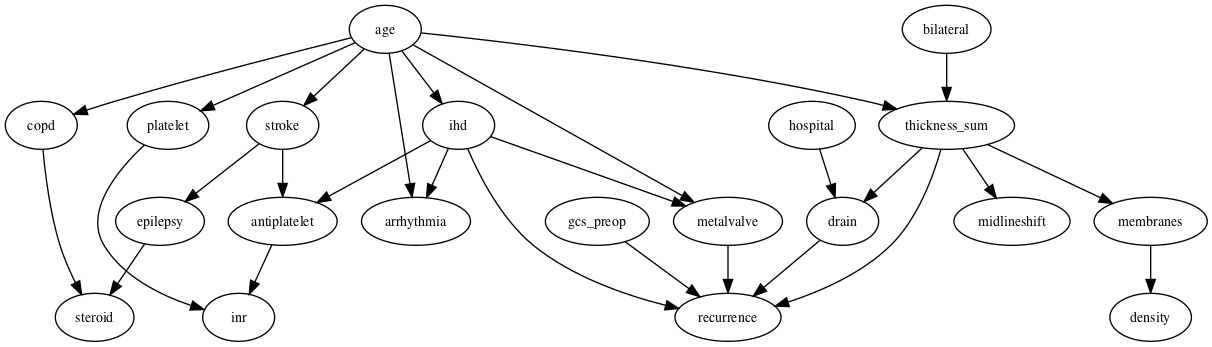

In [5]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

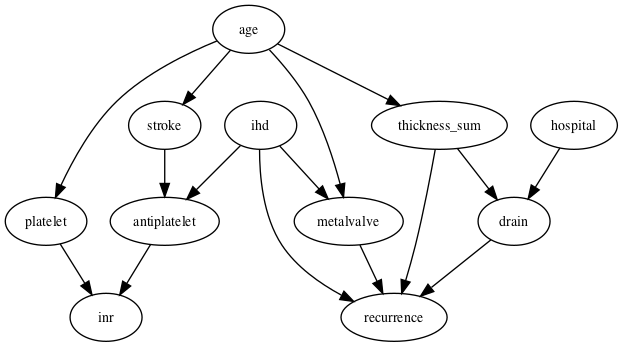

In [6]:
small_data_model = CausalModel(data=csdh,
                               treatment='drain', 
                               outcome='recurrence', 
                               graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
small_data_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [7]:
mp_estimand = mp_model.identify_effect(proceed_when_unidentifiable=True)
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)
small_data_estimand = small_data_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Propensity Score Weighting Estimator
### Inverse probability weighting (IPW) has been chosen


In [8]:
# Mask treatment variable as bool 
# DoWhy is still in development and does not support int treatments for propensity_score_weighting
csdh['drain'] = csdh['drain'].astype(bool)

In [9]:
# Propensity score matching
mp_weight_est = mp_model.estimate_effect(mp_estimand,
                                         method_name="backdoor.propensity_score_weighting",
                                         control_value=False,
                                         treatment_value=True,
                                         test_significance=True,
                                         confidence_intervals=True,
                                         method_params={"weighting_scheme":"ips_weight"}
                                        )

In [10]:
data_weight_est = data_model.estimate_effect(data_estimand,
                                             method_name="backdoor.propensity_score_weighting",
                                             control_value=False,
                                             treatment_value=True,
                                             test_significance=True,
                                             confidence_intervals=True,
                                             method_params={"weighting_scheme":"ips_weight"}
                                            )

In [11]:
sdata_weight_est = small_data_model.estimate_effect(small_data_estimand,
                                                    method_name="backdoor.propensity_score_weighting",
                                                    control_value=False,
                                                    treatment_value=True,
                                                    test_significance=True,
                                                    confidence_intervals=True,
                                                    method_params={"weighting_scheme":"ips_weight"}
                                                   )

In [12]:
print(mp_weight_est)
print(data_weight_est)
print(sdata_weight_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|adm_mrs,gcs_preop,age,thickness_sum,antiplatel
d[drain]                                                                      

    
et))
    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet,U) = P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet)

## Realized estimand
b: recurrence~drain+adm_mrs+gcs_preop+age+thickness_sum+antiplatelet
Target units: ate

## Estimate
Mean value: -0.11267092494077242
p-value: 0.001
95.0% confidence interval: (-0.16962328444516067, -0.04610915429100021)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression

In [13]:
# mp model
dwh.print_estimate_comparison(naive_est, mp_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.11267092494077242
Percentage change from naive_est: 20.425%
----------------------------------------------


In [14]:
# data model
dwh.print_estimate_comparison(naive_est, data_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.12135455420371477
Percentage change from naive_est: 29.706%
----------------------------------------------


In [15]:
# small data model
dwh.print_estimate_comparison(naive_est, sdata_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.11129408031591095
Percentage change from naive_est: 18.953%
----------------------------------------------


---
### III. IPW Interpreters

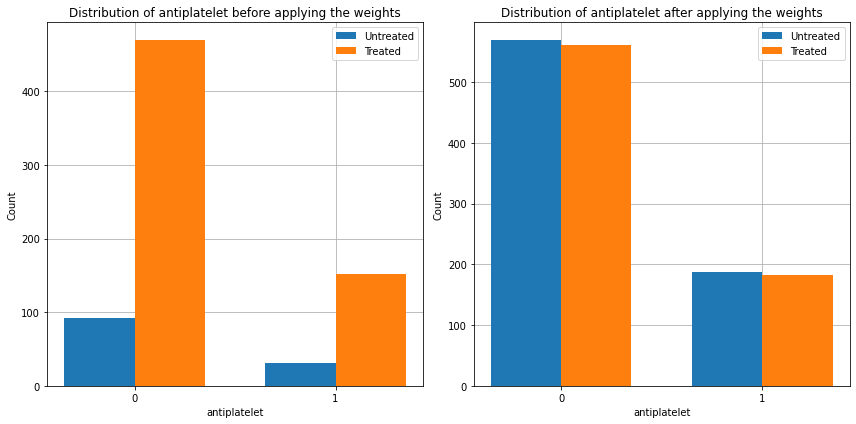

In [16]:
dwh.plot_ipw_interpreter(mp_weight_est, 'antiplatelet')

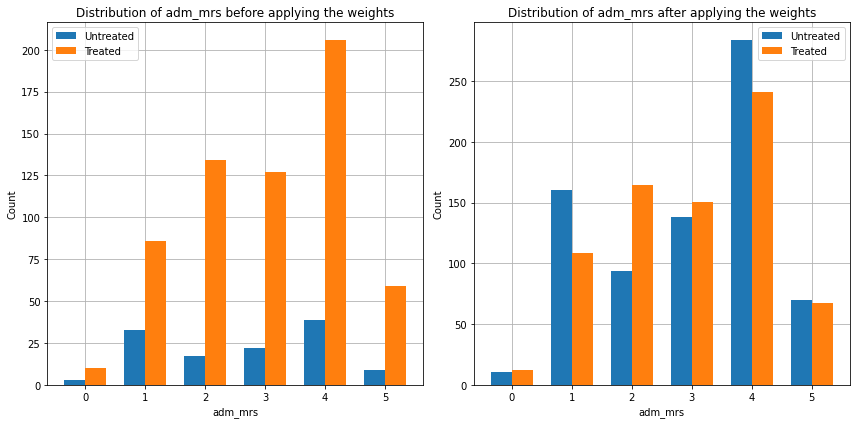

In [17]:
dwh.plot_ipw_interpreter(mp_weight_est, 'adm_mrs')

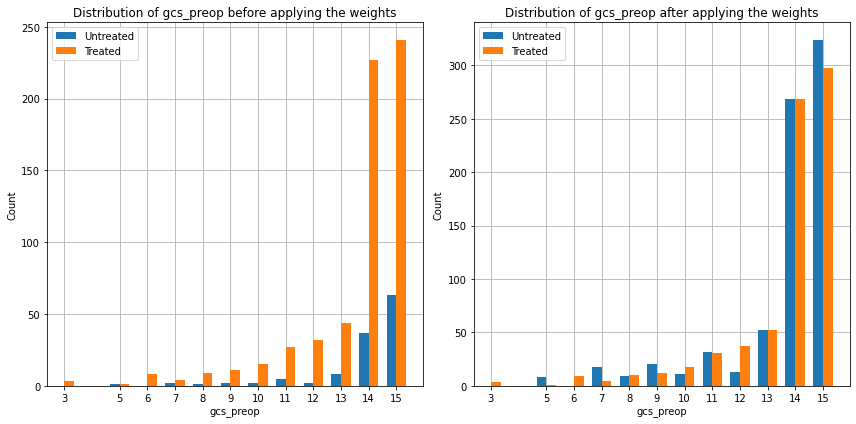

In [18]:
dwh.plot_ipw_interpreter(mp_weight_est, 'gcs_preop')

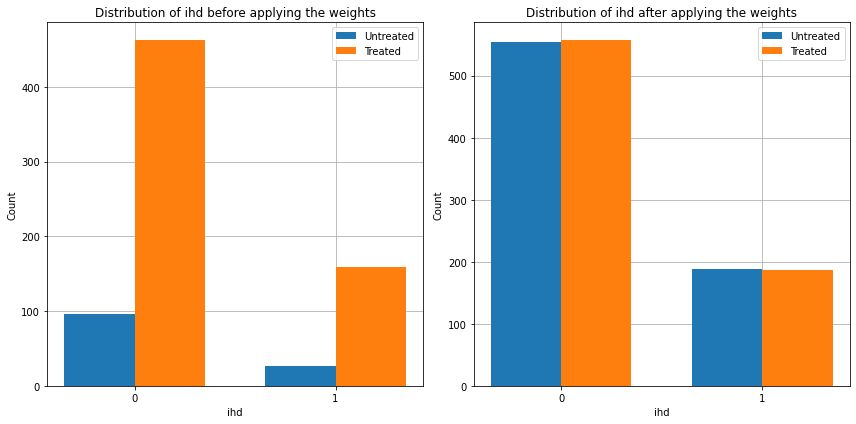

In [19]:
dwh.plot_ipw_interpreter(data_weight_est, 'ihd')

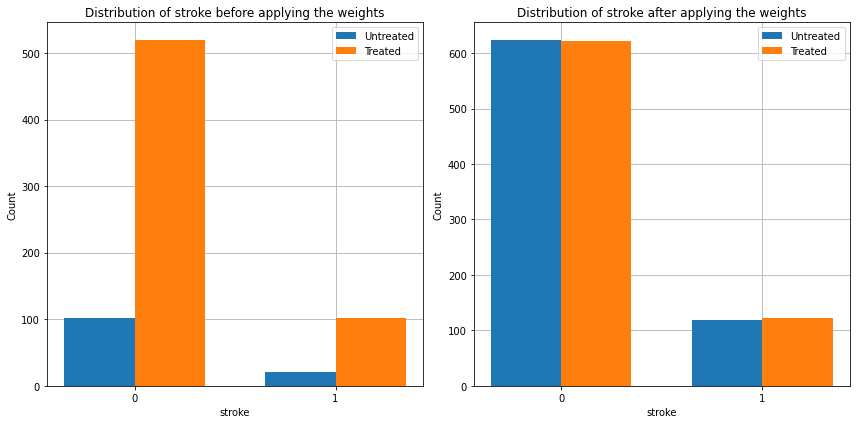

In [20]:
dwh.plot_ipw_interpreter(sdata_weight_est, 'stroke')

---
## IV. Refute the obtained estimate


1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [27]:
mp_ran_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                 mp_weight_est, 
                                                 num_simulations=2,
                                                 method_name='random_common_cause')

In [28]:
data_ran_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                     data_weight_est, 
                                                     num_simulations=2,
                                                     method_name='random_common_cause')

In [29]:
sdata_ran_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                            sdata_weight_est,
                                                            num_simulations=2,
                                                            method_name='random_common_cause')

In [30]:
# Robust if: new estimate is similar to estimated effect
print(mp_ran_weight_refuter)
print(data_ran_weight_refuter)
print(sdata_ran_weight_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.11267092494077242
New effect:-0.11238603813849474

Refute: Add a Random Common Cause
Estimated effect:-0.12135455420371477
New effect:-0.11859439497732174

Refute: Add a Random Common Cause
Estimated effect:-0.11129408031591095
New effect:-0.1154718756756758



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [31]:
mp_placebo_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                     mp_weight_est,
                                                     placebo_type='permute',
                                                     num_similations=2,
                                                     method_name='placebo_treatment_refuter')

In [32]:
data_placebo_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                         data_weight_est,
                                                         placebo_type='permute',
                                                         num_similations=2,
                                                         method_name='placebo_treatment_refuter')

In [33]:
sdata_placebo_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                                sdata_weight_est,
                                                                placebo_type='permute',
                                                                num_similations=2,
                                                                method_name='placebo_treatment_refuter')

In [34]:
print(mp_placebo_weight_refuter)
print(data_placebo_weight_refuter)
print(sdata_placebo_weight_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.11267092494077242
New effect:0.004047909182004586
p value:0.44

Refute: Use a Placebo Treatment
Estimated effect:-0.12135455420371477
New effect:0.003644924467052284
p value:0.47

Refute: Use a Placebo Treatment
Estimated effect:-0.11129408031591095
New effect:0.003431502072054004
p value:0.45



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [41]:
mp_dummy_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                   mp_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [42]:
data_dummy_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [43]:
sdata_dummy_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                   sdata_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [44]:
print(mp_dummy_weight_refuter[0])
print(data_dummy_weight_refuter[0])
print(sdata_dummy_weight_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.09926810515516836
p value:0.042012105151955005

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.028707444250954273
p value:0.3669313398602138

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.019030124052187073
p value:0.4177183167911614



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [45]:
mp_subset_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [46]:
data_subset_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [47]:
sdata_subset_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [48]:
print(mp_subset_weight_refuter)
print(data_subset_weight_refuter)
print(sdata_subset_weight_refuter)

Refute: Use a subset of data
Estimated effect:-0.11267092494077242
New effect:-0.11591332898719835
p value:0.3524692717486111

Refute: Use a subset of data
Estimated effect:-0.12135455420371477
New effect:-0.11893962578255177
p value:0.43085976421029215

Refute: Use a subset of data
Estimated effect:-0.11129408031591095
New effect:-0.09945383396001861
p value:0.17458718137125434



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [53]:
mp_bootstrap_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [54]:
data_bootstrap_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [55]:
sdata_bootstrap_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [56]:
print(mp_bootstrap_weight_refuter)
print(data_bootstrap_weight_refuter)
print(sdata_bootstrap_weight_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11267092494077242
New effect:-0.09847626017550651
p value:0.3379276840378701

Refute: Bootstrap Sample Dataset
Estimated effect:-0.12135455420371477
New effect:-0.1095200509208308
p value:0.4141589519707588

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11129408031591095
New effect:-0.09525048592883414
p value:0.3759183817217274

